In [1]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models 
from PIL import ImageOps
from torchsummary import summary
from collections import Counter
import torchvision
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

## Seeds

In [2]:
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

## Some necessary setting

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % DEVICE)
print("You are using PyTorch version: %s" % torch.__version__)
CRACK_CLASSES = [
    'Diagonal',
    'Horizontal',
    'Vertical',
    'X-shape'
]
NUM_CLASSES = len(CRACK_CLASSES)

You are using device: cuda
You are using PyTorch version: 2.5.1


## Data loading and processing

In [4]:
class MultiLabel_ImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform = None, target_transform = None):
        super().__init__(root, transform, target_transform)

        self.class_to_idx = {cls: i for i, cls in enumerate(CRACK_CLASSES)}
        self.classes = CRACK_CLASSES
    
    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        muti_hot = torch.zeros(NUM_CLASSES, dtype=torch.float32)
        muti_hot[target] = 1.0
        
        return img, muti_hot

def train_transform():
    # 多個可選的增強策略（不改變方向）
    augmentation_choices = [
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.GaussianBlur(kernel_size=(3, 3)),
        transforms.RandomAffine(degrees=0, scale=(1.2, 1.5)) ,
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(1.0, 1.0)), 
    ]

    chosen_aug = random.choice(augmentation_choices)
    
    train_df = transforms.Compose([
        transforms.Resize((224, 224)),
        chosen_aug, 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    return train_df

def val_transform():

    val_df = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return val_df


In [5]:
def load_dataset(path, batch_size = 16):
    val_tf = val_transform()

    full_dataset = MultiLabel_ImageFolder(root=path, transform=val_tf)

    indices = list(range(len(full_dataset)))
    single_labels = [torch.argmax(full_dataset[i][1]).item() for i in indices] # 資料分割前label要先轉回整數
    train_idx, val_idx = train_test_split(indices, test_size=0.1, stratify=single_labels, random_state=42)

    train_set = Subset(full_dataset, train_idx)
    val_set = Subset(full_dataset, val_idx)

    train_set.dataset.transform = train_transform()
    val_set.dataset.transform = val_tf

    train_counts = Counter([torch.argmax(train_set[i][1]).item() for i in range(len(train_set))])
    val_counts = Counter([torch.argmax(val_set[i][1]).item() for i in range(len(val_set))])
    print('每類別資料數量:\n')
    for i, name in enumerate(CRACK_CLASSES):
        print(f'{name:<20} train:{train_counts[i]:4d} val:{val_counts[i]:4d}')
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, single_labels

path = "D:/Deep_Learning homework/finial_competition/crack_classification/resized/column"
train_loader, val_loader, single_labels= load_dataset(path)


每類別資料數量:

Diagonal             train: 211 val:  24
Horizontal           train: 139 val:  16
Vertical             train: 187 val:  21
X-shape              train:  95 val:  10


## Define Model

In [6]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

def crack_model(num_classes=4, freeze_backbone=True):
    weights = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1
    model = vit_l_16(weights=weights)

    in_features = model.heads.head.in_features

    # 自定義分類頭
    model.heads.head = nn.Sequential(
        nn.LayerNorm(in_features),
        nn.Dropout(0.5),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

    if freeze_backbone:
        # 先全部凍結
        for param in model.parameters():
            param.requires_grad = False

        # 解凍分類頭
        for param in model.heads.parameters():
            param.requires_grad = True

        # 解凍最後 3 個 encoder blocks
        encoder_blocks = model.encoder.layers  # transformer blocks
        for block in encoder_blocks[-2:]:
            for param in block.parameters():
                param.requires_grad = True

        # 解凍所有 LayerNorm 或 normalization 層
        for module in model.modules():
            if isinstance(module, (nn.LayerNorm, nn.BatchNorm2d)):
                for param in module.parameters():
                    param.requires_grad = True

    return model, weights.transforms()



# 使用方式
model, preprocess = crack_model(num_classes=4, freeze_backbone=True)
model = model.to(DEVICE)


## Train Model

In [7]:
def compute_accuracy(outputs, labels, thr=0.5):
    preds = (torch.sigmoid(outputs) > thr).float()
    correct_per_class = (preds == labels).float().mean(dim=0)
    return correct_per_class.mean().item()

def compute_macro_f1(outputs, labels, thr=0.5):
    preds = (torch.sigmoid(outputs) > thr).float().cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, preds, average='macro')

In [8]:
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-5, patience=7):
    FACTORS = torch.tensor([1.75, 0.7, 1.65, 1.7])
    counts = Counter(single_labels)
    class_counts = torch.tensor([counts[i] for i in range(NUM_CLASSES)], dtype=torch.float32)
    total = class_counts.sum()
    pos_weight = (total - class_counts) / class_counts
    pos_weight = (pos_weight * FACTORS).to(DEVICE)

    print("class_counts :", class_counts.tolist())
    print("pos_weight   :", pos_weight.tolist())

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        div_factor=25,
        final_div_factor=1e4
    )

    best_f1 = 0.0
    wait = 0

    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_acc += acc

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        all_outputs, all_labels = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                acc = compute_accuracy(outputs, labels)

                val_loss += loss.item()
                val_acc += acc

                all_outputs.append(outputs)
                all_labels.append(labels)

        # 合併整個驗證集的輸出與標籤來計算 macro F1
        all_outputs = torch.cat(all_outputs, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        macro_f1 = compute_macro_f1(all_outputs, all_labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print('==========================')
        print(f"Epoch {epoch+1}:")
        print(f"Train Loss={train_loss:.4f} Acc={train_acc:.4f}")
        print(f"Val   Loss={val_loss:.4f} Acc={val_acc:.4f} Macro F1={macro_f1:.4f}")

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        # 用 Macro F1 儲存模型
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            wait = 0
            torch.save(model.state_dict(), "best_model_crack.pth")
            print(">> Saved best model (Macro F1)")
            print('==========================')
        else:
            wait += 1
            if wait >= patience:
                print(">> Early stopping")
                print('==========================')
                break

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, epochs=80)


class_counts : [235.0, 155.0, 208.0, 105.0]
pos_weight   : [3.4851064682006836, 2.4748387336730957, 3.926682710647583, 9.681904792785645]


Epoch 1/80 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 1:
Train Loss=1.2925 Acc=0.5488
Val   Loss=1.2480 Acc=0.5612 Macro F1=0.2133
>> Saved best model (Macro F1)


Epoch 2/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 2:
Train Loss=1.2732 Acc=0.5316
Val   Loss=1.2337 Acc=0.5384 Macro F1=0.2431
>> Saved best model (Macro F1)


Epoch 3/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 3:
Train Loss=1.2580 Acc=0.4973
Val   Loss=1.2126 Acc=0.4679 Macro F1=0.3376
>> Saved best model (Macro F1)


Epoch 4/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 4:
Train Loss=1.2520 Acc=0.4773
Val   Loss=1.1892 Acc=0.4049 Macro F1=0.3382
>> Saved best model (Macro F1)


Epoch 5/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 5:
Train Loss=1.2156 Acc=0.4516
Val   Loss=1.1661 Acc=0.3821 Macro F1=0.3577
>> Saved best model (Macro F1)


Epoch 6/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 6:
Train Loss=1.1747 Acc=0.4242
Val   Loss=1.1415 Acc=0.3884 Macro F1=0.3819
>> Saved best model (Macro F1)


Epoch 7/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 7:
Train Loss=1.1664 Acc=0.4461
Val   Loss=1.1017 Acc=0.4286 Macro F1=0.3678


Epoch 8/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 8:
Train Loss=1.1126 Acc=0.5008
Val   Loss=1.0569 Acc=0.5366 Macro F1=0.4339
>> Saved best model (Macro F1)


Epoch 9/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 9:
Train Loss=1.0567 Acc=0.5828
Val   Loss=1.0045 Acc=0.5612 Macro F1=0.5062
>> Saved best model (Macro F1)


Epoch 10/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 10:
Train Loss=1.0303 Acc=0.5953
Val   Loss=0.9569 Acc=0.6545 Macro F1=0.5660
>> Saved best model (Macro F1)


Epoch 11/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 11:
Train Loss=0.9803 Acc=0.6375
Val   Loss=0.9485 Acc=0.6616 Macro F1=0.5767
>> Saved best model (Macro F1)


Epoch 12/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 12:
Train Loss=0.9093 Acc=0.6727
Val   Loss=0.9134 Acc=0.6723 Macro F1=0.5975
>> Saved best model (Macro F1)


Epoch 13/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch 13:
Train Loss=0.8560 Acc=0.7102
Val   Loss=0.8152 Acc=0.7487 Macro F1=0.6411
>> Saved best model (Macro F1)


Epoch 14/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch 14:
Train Loss=0.7836 Acc=0.7648
Val   Loss=0.7497 Acc=0.7705 Macro F1=0.6680
>> Saved best model (Macro F1)


Epoch 15/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


Epoch 15:
Train Loss=0.6938 Acc=0.7957
Val   Loss=0.7282 Acc=0.8018 Macro F1=0.6903
>> Saved best model (Macro F1)


Epoch 16/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 16:
Train Loss=0.6168 Acc=0.8285
Val   Loss=0.6864 Acc=0.8442 Macro F1=0.7263
>> Saved best model (Macro F1)


Epoch 17/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 17:
Train Loss=0.6134 Acc=0.8449
Val   Loss=0.8479 Acc=0.7777 Macro F1=0.6545


Epoch 18/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch 18:
Train Loss=0.5920 Acc=0.8473
Val   Loss=0.6880 Acc=0.8598 Macro F1=0.7509
>> Saved best model (Macro F1)


Epoch 19/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Epoch 19:
Train Loss=0.5024 Acc=0.8824
Val   Loss=0.6667 Acc=0.8763 Macro F1=0.7657
>> Saved best model (Macro F1)


Epoch 20/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 20:
Train Loss=0.4452 Acc=0.9059
Val   Loss=0.6706 Acc=0.8567 Macro F1=0.7359


Epoch 21/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 21:
Train Loss=0.4054 Acc=0.9219
Val   Loss=0.7688 Acc=0.8598 Macro F1=0.7529


Epoch 22/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 22:
Train Loss=0.4037 Acc=0.9191
Val   Loss=0.6696 Acc=0.8826 Macro F1=0.7714
>> Saved best model (Macro F1)


Epoch 23/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 23:
Train Loss=0.3477 Acc=0.9434
Val   Loss=0.7117 Acc=0.8763 Macro F1=0.7620


Epoch 24/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 24:
Train Loss=0.5589 Acc=0.8777
Val   Loss=0.5882 Acc=0.8826 Macro F1=0.7809
>> Saved best model (Macro F1)


Epoch 25/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 25:
Train Loss=0.3924 Acc=0.9250
Val   Loss=0.6216 Acc=0.8763 Macro F1=0.7605


Epoch 26/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 26:
Train Loss=0.3033 Acc=0.9457
Val   Loss=0.6605 Acc=0.8732 Macro F1=0.7478


Epoch 27/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 27:
Train Loss=0.2761 Acc=0.9598
Val   Loss=0.6812 Acc=0.8763 Macro F1=0.7570


Epoch 28/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 28:
Train Loss=0.2562 Acc=0.9648
Val   Loss=0.7340 Acc=0.8763 Macro F1=0.7630


Epoch 29/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 29:
Train Loss=0.2341 Acc=0.9672
Val   Loss=0.7175 Acc=0.8888 Macro F1=0.7928
>> Saved best model (Macro F1)


Epoch 30/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 30:
Train Loss=0.2083 Acc=0.9773
Val   Loss=0.6897 Acc=0.8888 Macro F1=0.7879


Epoch 31/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 31:
Train Loss=0.1969 Acc=0.9805
Val   Loss=0.7648 Acc=0.8888 Macro F1=0.7815


Epoch 32/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 32:
Train Loss=0.1651 Acc=0.9863
Val   Loss=0.7892 Acc=0.8795 Macro F1=0.7616


Epoch 33/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 33:
Train Loss=0.1710 Acc=0.9855
Val   Loss=0.7917 Acc=0.8795 Macro F1=0.7593


Epoch 34/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 34:
Train Loss=0.1519 Acc=0.9867
Val   Loss=0.8109 Acc=0.8795 Macro F1=0.7659


Epoch 35/80 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Epoch 35:
Train Loss=0.1472 Acc=0.9898
Val   Loss=0.8300 Acc=0.8857 Macro F1=0.7786


Epoch 36/80 [Val]: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

Epoch 36:
Train Loss=0.1404 Acc=0.9898
Val   Loss=0.8533 Acc=0.8857 Macro F1=0.7783
>> Early stopping


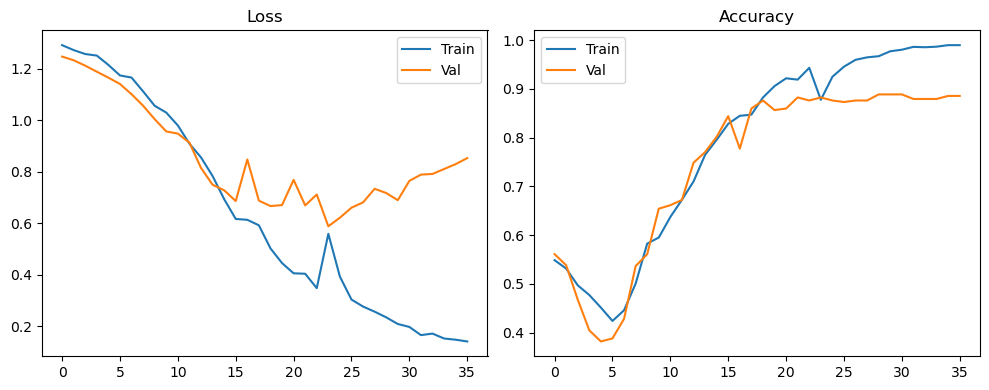

In [9]:
def plot_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_history(train_loss, train_acc, val_loss, val_acc)

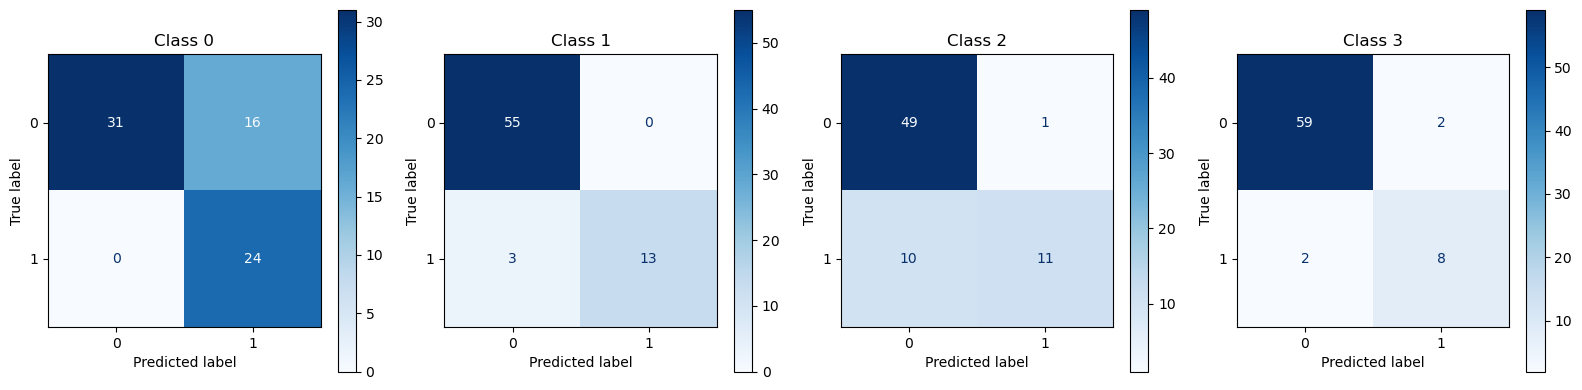

              precision    recall  f1-score   support

     Class 0       0.60      1.00      0.75        24
     Class 1       1.00      0.81      0.90        16
     Class 2       0.92      0.52      0.67        21
     Class 3       0.80      0.80      0.80        10

   micro avg       0.75      0.79      0.77        71
   macro avg       0.83      0.78      0.78        71
weighted avg       0.81      0.79      0.77        71
 samples avg       0.76      0.79      0.77        71



In [10]:
def show_confusion_matrix(model, val_loader, class_names=None, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # 多標籤機率
            preds = (probs > threshold).int().cpu().numpy()
            targets = labels.int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(targets)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    mcm = multilabel_confusion_matrix(all_labels, all_preds)

    num_classes = mcm.shape[0]
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    # 畫出每一類的 confusion matrix
    fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(4 * num_classes, 4))
    if num_classes == 1:
        axes = [axes]  # 保持 list 型式

    for i in range(num_classes):
        cm = mcm[i]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["0", "1"])
        disp.plot(ax=axes[i], cmap="Blues", values_format='d')
        axes[i].set_title(class_names[i])

    plt.tight_layout()
    plt.show()
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
show_confusion_matrix(model, val_loader)